In [ ]:
#We stablish conection with google drive (just in case you are working with Google Colab)
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
%cd "/content/drive/My Drive/Colab_Notebooks/Data_Science/4_Classification"

/content/drive/My Drive/Colab_Notebooks/Data_Science/4_Classification


# Setup

In [ ]:
!pip install tensorflow opencv-python

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import cv2
import imghdr
import pandas as pd

In [ ]:
os.path.join('dataset', 'notumor')

'dataset/notumor'

In [ ]:
os.listdir()

['dataset', '4_Classification.ipynb']

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpus[0], True)

# Load data

The dataset was extracted from Kaggle:[Brain Tumor MRI Dataset](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset)

all the images from each class were put back together to start this project

In [ ]:
data_dir = "dataset"

In [ ]:
image_exts = ['jpg', 'jpeg', 'bmp', 'png']

In [ ]:
# To remove all the dodgy data
#for image_class in os.listdir(data_dir):
#  for image in os.listdir(os.path.join(image_class, image)):
#    image_path = os.path.join(data_dir, image_class, image)
#    try:
#      img = cv2.read(image_path)
#      tip = imghdr.what(image_path)
#      if tip not in image_exts:
#        print('Image not in ext list{}'.format(image_path))
#        os.remove(image_path)
#    except Exception as e:
#      print('Issue with image {}'.format(image_path))


For more information about image_dataset_from_directory go to this [link](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory)

the labels are setted as:
"Labels should be sorted according to the alphanumeric order of the image file paths (obtained via os.walk(directory) in Python)."

In [ ]:
data = tf.keras.utils.image_dataset_from_directory('dataset')

Found 6689 files belonging to 4 classes.


In [ ]:
data_iterator = data.as_numpy_iterator()

In [ ]:
batch = data_iterator.next()

In [ ]:
batch[0].shape

(32, 256, 256, 3)

In [ ]:
batch[1]

array([2, 1, 1, 3, 2, 2, 2, 2, 2, 2, 0, 1, 1, 2, 0, 2, 3, 0, 2, 1, 3, 3,
       2, 1, 2, 2, 0, 2, 0, 2, 2, 3], dtype=int32)

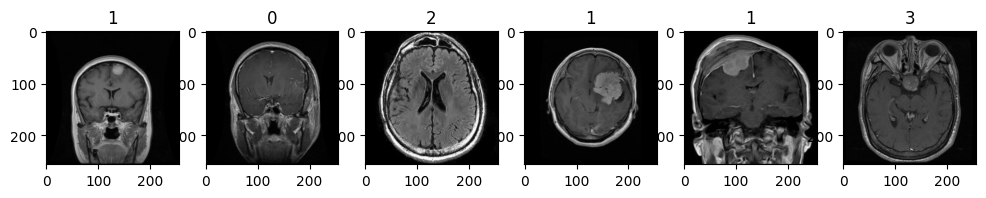

In [ ]:
fig, ax = plt.subplots(ncols=6, figsize=[12,12])
for idx, img in enumerate(batch[0][:6]):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(batch[1][idx])

0. Glioma
1. Meningioma
2. notumor
3. pituitary



# Preprocessing Data pipeline

In [ ]:
data = data.map(lambda x,y: (x/255, y))

In [ ]:
data.as_numpy_iterator().next()[0].shape

(32, 256, 256, 3)

In [ ]:
# Set training, validating and testing dataset
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [ ]:
len(data)

210

In [ ]:
#this sum should fit to the lenght of batches
train_size + val_size + test_size

210

In [ ]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

In [ ]:
len(test)

21

# Deep Learning Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [ ]:
model = Sequential()

In [ ]:
model.add(Conv2D(16, (3, 3), 1, activation='relu', input_shape=(256, 256, 3), kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.30))

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(4, activation='softmax'))

In [ ]:
model.compile('adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 127, 127, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 62, 62, 32)        0

# Train the Model

In [ ]:
np.random.seed(2)

In [ ]:
logdir = 'logs'

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

In [ ]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


147/147 [==============================] - 1778s 12s/step - loss: 1.0610 - accuracy: 0.5642 - val_loss: 0.7763 - val_accuracy: 0.6912
Epoch 2/20
147/147 [==============================] - 41s 275ms/step - loss: 0.5841 - accuracy: 0.7830 - val_loss: 0.6446 - val_accuracy: 0.7113
Epoch 3/20
147/147 [==============================] - 60s 408ms/step - loss: 0.4466 - accuracy: 0.8352 - val_loss: 0.4450 - val_accuracy: 0.8229
Epoch 4/20
147/147 [==============================] - 60s 408ms/step - loss: 0.3432 - accuracy: 0.8735 - val_loss: 0.3872 - val_accuracy: 0.8482
Epoch 5/20
147/147 [==============================] - 42s 281ms/step - loss: 0.2615 - accuracy: 0.9080 - val_loss: 0.3529 - val_accuracy: 0.8728
Epoch 6/20
147/147 [==============================] - 60s 408ms/step - loss: 0.2140 - accuracy: 0.9271 - val_loss: 0.2442 - val_accuracy: 0.9263
Epoch 7/20
147/147 [==============================] - 41s 278ms/step - loss: 0.1614 - accuracy: 0.9496 - val_loss: 0.2323 - val_accuracy: 0.9

In [ ]:
hist.history

In [ ]:
import matplotlib.ticker as mticker

<ipython-input-91-d9a99b82aebb>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x)


<function matplotlib.pyplot.show(close=None, block=None)>

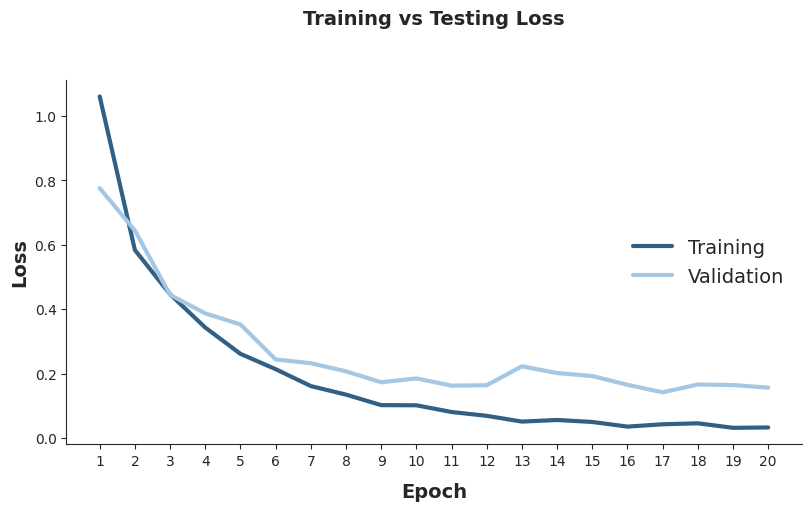

In [ ]:
fig, ax = plt.subplots(layout='constrained', figsize=(8,5))
sns.set_style("ticks")
x = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
sns.lineplot(hist.history['loss'], color='#326085', label='Training', linewidth=3)
sns.lineplot(hist.history['val_loss'], color='#A3C7E5', label='Validation', legend=True, linewidth=3)

sns.despine()
plt.title("Training vs Testing Loss", fontsize=14, pad=40, fontweight='bold')
ax.legend(fontsize=14, loc='center right', edgecolor='white')
ax.set_xlabel("Epoch", fontsize=14, fontweight="bold", labelpad=10)
ax.set_ylabel("Loss", fontsize=14, fontweight="bold")
ax.set_xticklabels(x)
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))

plt.show

<ipython-input-90-6badd7bcb2a0>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x)


<function matplotlib.pyplot.show(close=None, block=None)>

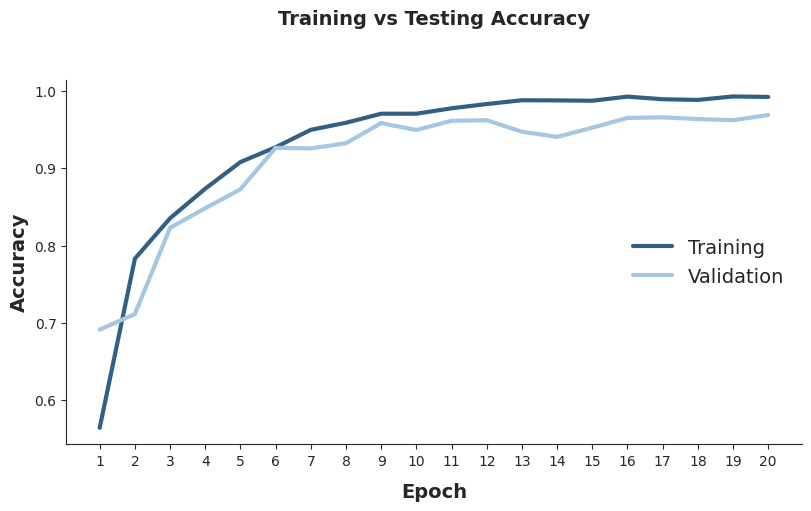

In [ ]:
fig, ax = plt.subplots(layout='constrained', figsize=(8,5))
sns.set_style("ticks")
x = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
sns.lineplot(hist.history['accuracy'], color='#326085', label='Training', linewidth=3)
sns.lineplot(hist.history['val_accuracy'],color='#A3C7E5', label='Validation', legend=True, linewidth=3)

sns.despine()
plt.title("Training vs Testing Accuracy", fontsize=14, pad=40, fontweight='bold')
ax.legend(fontsize=14, loc='center right', edgecolor='white')
ax.set_xlabel("Epoch", fontsize=14, fontweight="bold", labelpad=10)
ax.set_ylabel("Accuracy", fontsize=14, fontweight="bold")
ax.set_xticklabels(x)
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))

plt.show

# Evaluate the model (Test)

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, SparseCategoricalAccuracy

In [ ]:
acc = SparseCategoricalAccuracy()

In [ ]:
for batch in test.as_numpy_iterator():
  X, y = batch
  yhat = model.predict(X)
  acc.update_state(y, yhat)

1/1 [==============================] - 0s 283ms/step


In [ ]:
Test_Accuracy= acc.result().numpy().round(2)

In [ ]:
print(f'Accuracy: {Test_Accuracy:.2f}')

Accuracy: 0.95


# Save and Load the Model

In [ ]:
from tensorflow.keras.models import load_model
import pickle

In [ ]:
# Save the trained model
with open('/models', 'wb') as file_pi:
    pickle.dump(hist.history, file_pi)

In [ ]:
# Load the trained model
with open('/models', "rb") as file_pi:
    history = pickle.load(file_pi)

In [ ]:
# Save the model without training
#model.save(os.path.join('models', 'brain_cancer_best.h5'))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Load the model without training
new_model = load_model(os.path.join('models', 'brain_cancer_best.h5'))

# Evaluate with an external image

The [image](https://www.google.com/url?sa=i&url=http%3A%2F%2Fwww.svuhradiology.ie%2Fcase-study%2Fmeningioma%2F&psig=AOvVaw2fzDrb8OdobiXQ2i04MKJ0&ust=1704595691238000&source=images&cd=vfe&opi=89978449&ved=0CBIQjRxqFwoTCMipupzgx4MDFQAAAAAdAAAAABAD) use to do the external test were obtained from the [Radiology from St. Vincent's University Hospital](http://www.svuhradiology.ie/case-study/meningioma/)

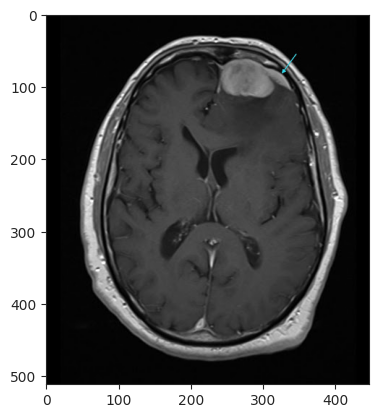

In [ ]:
img = cv2.imread('external_test.jpeg')
plt.imshow(img)
plt.show()

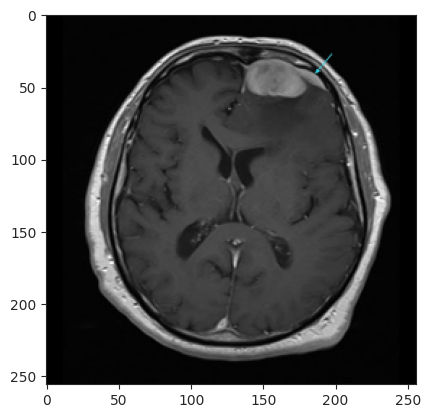

In [ ]:
img_resize = tf.image.resize(img, (256,256))
plt.imshow(img_resize.numpy().astype(int))
plt.show()

the model expect a batch of images. Therefore the expand function from numpy is needed

In [ ]:
final_image = np.expand_dims(img_resize/255, 0)

In [ ]:
yhat = new_model.predict(final_image)

1/1 [==============================] - 0s 74ms/step


Classification:
0. Glioma
1. Meningioma
2. notumor
3. pituitary

In [ ]:
def forecast(yhat):
  match np.argmax(yhat):
    case 0:
      print('This MRI fits with a glioma cancer')
    case 1:
      print('This MRI fits with a meningioma cancer')
    case 2:
      print('This MRI fits with a brain without tumor')
    case 3:
      print('This MRI fits with a pituitary cancer')

In [ ]:
forecast(yhat)

This MRI fits with a meningioma cancer
